# Hierarchical clustering program using different distance measures

Use pm4py for importing different event logs found in logs folder

In [1]:
# Reloads the local files if they change
%load_ext autoreload
%autoreload 2

# import local files
import Jaccard
import Simrank
import Log_processing
import Clustering
import Comparison

import matplotlib.pyplot as plt

In [2]:
# TESTING
def weighted_simrank(G, node1, node2, C=0.8, max_iterations=100, tolerance=1e-6):
    if node1 == node2:
        return 1.0

    prev_sim = 0
    sim = 1
    iterations = 0

    while abs(sim - prev_sim) > tolerance and iterations < max_iterations:
        prev_sim = sim
        neighbors1 = set(G.predecessors(node1))
        neighbors2 = set(G.predecessors(node2))
        sim = C / (len(neighbors1) * len(neighbors2)) * sum(G[node1][x]['weight'] * G[node2][y]['weight'] * weighted_simrank(G, x, y, C, max_iterations, tolerance) for x in neighbors1 for y in neighbors2)
        iterations += 1

    return sim

def full_weighted_simrank(G):
    similarities = {}
    for node1 in G.nodes():
        node_similarity = {}
        for node2 in G.nodes():
            node_similarity[node2] = weighted_simrank(G, node1, node2)
        similarities[node1] = {}

Analyze the Sepsis event log

parsing log, completed traces ::   0%|          | 0/1050 [00:00<?, ?it/s]

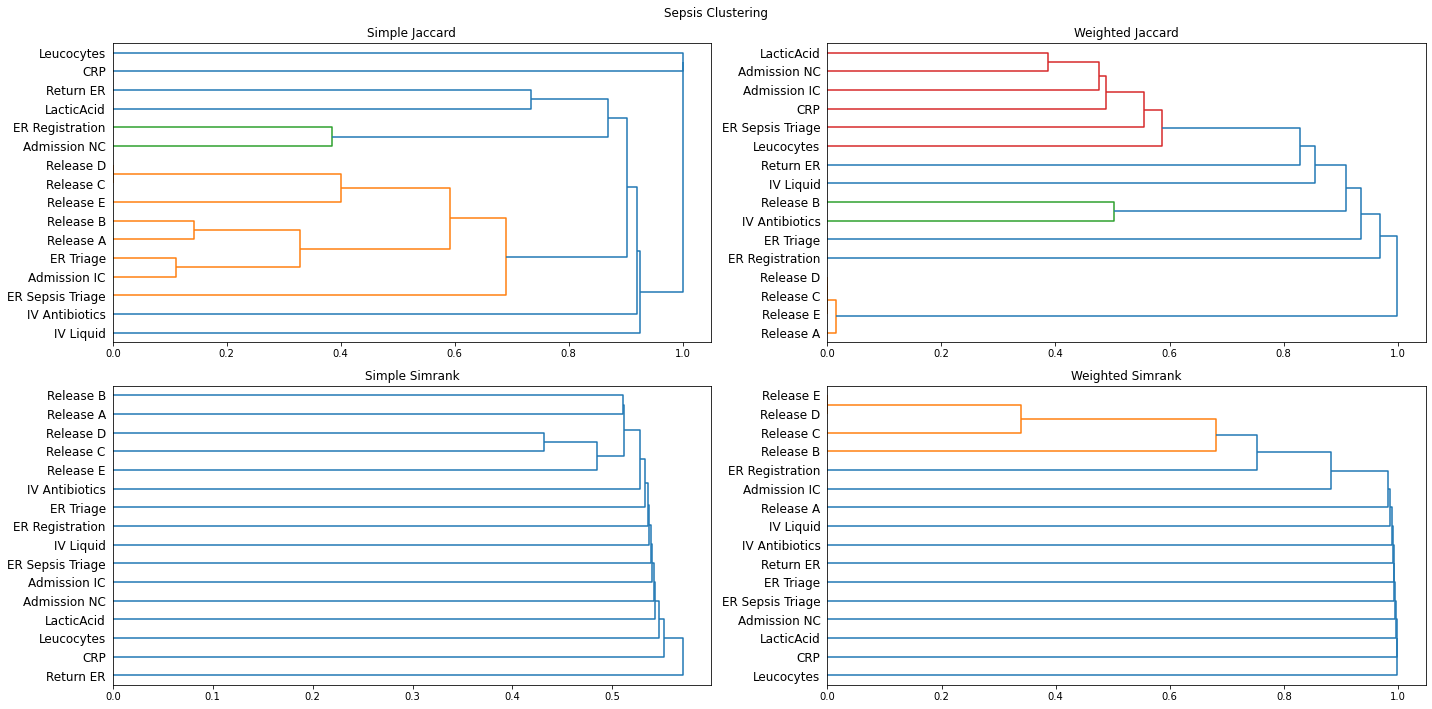

In [3]:
sepsis = Log_processing.get_log("../logs/sepsis_event_log.xes")
Comparison.show_dendrograms_for_event_log(sepsis, "Sepsis Clustering", "sepsis.jpg")

Analyze the Coselog event log

parsing log, completed traces ::   0%|          | 0/1434 [00:00<?, ?it/s]

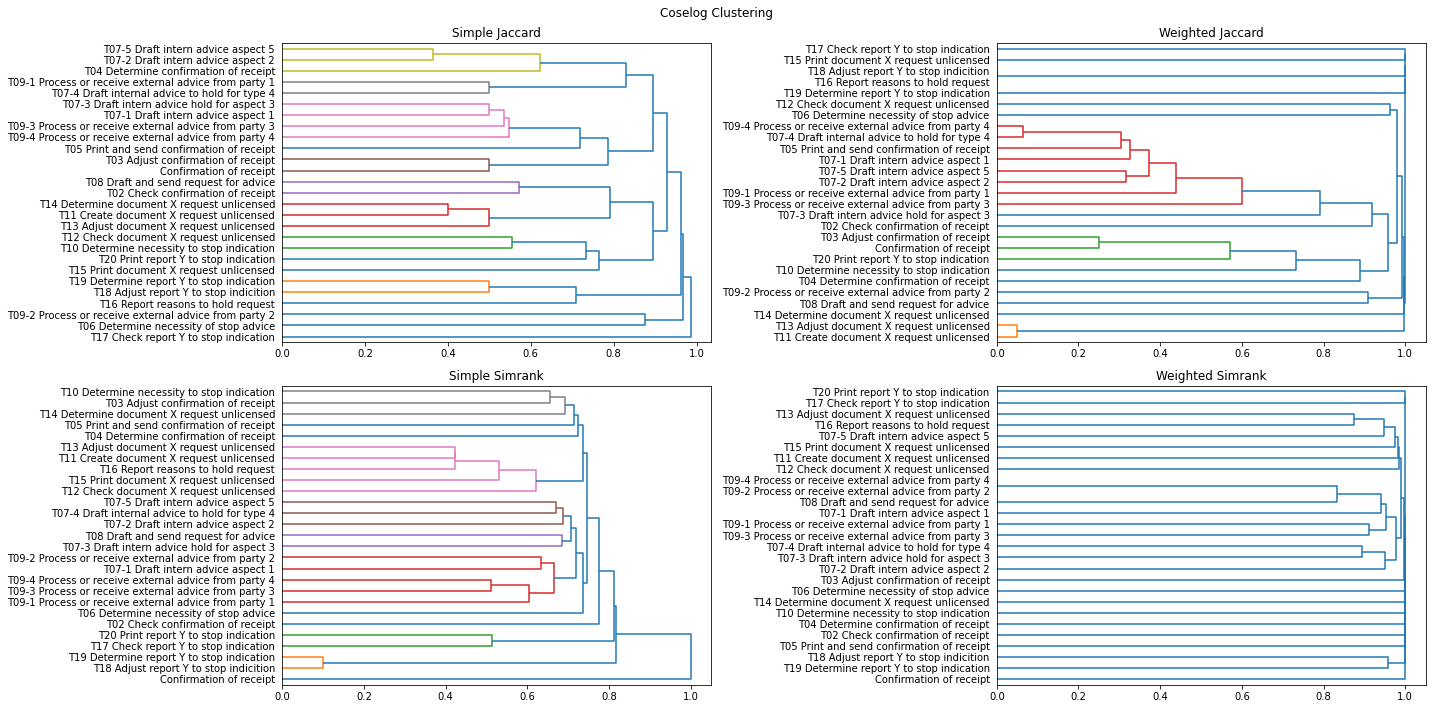

In [4]:
coselog = Log_processing.get_log("../logs/coselog.xes")
Comparison.show_dendrograms_for_event_log(coselog, "Coselog Clustering", "coselog.jpg")

Analyze the BPI Challenge event log

parsing log, completed traces ::   0%|          | 0/7554 [00:00<?, ?it/s]

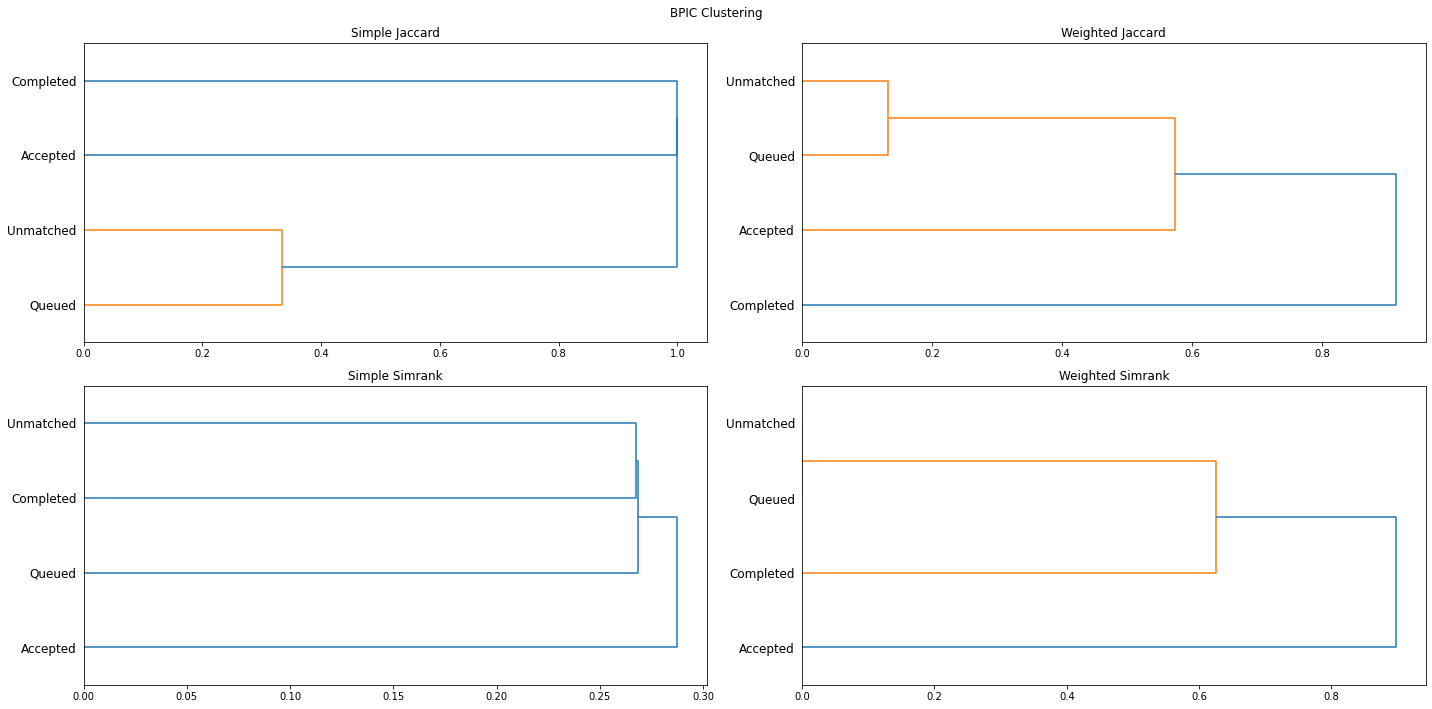

In [5]:
bpic = Log_processing.get_log("../logs/BPI_Challenge_2013_incidents.xes")
Comparison.show_dendrograms_for_event_log(bpic, "BPIC Clustering", "bpic.jpg")

Analyze the Road traffic fine event log

parsing log, completed traces ::   0%|          | 0/150370 [00:00<?, ?it/s]

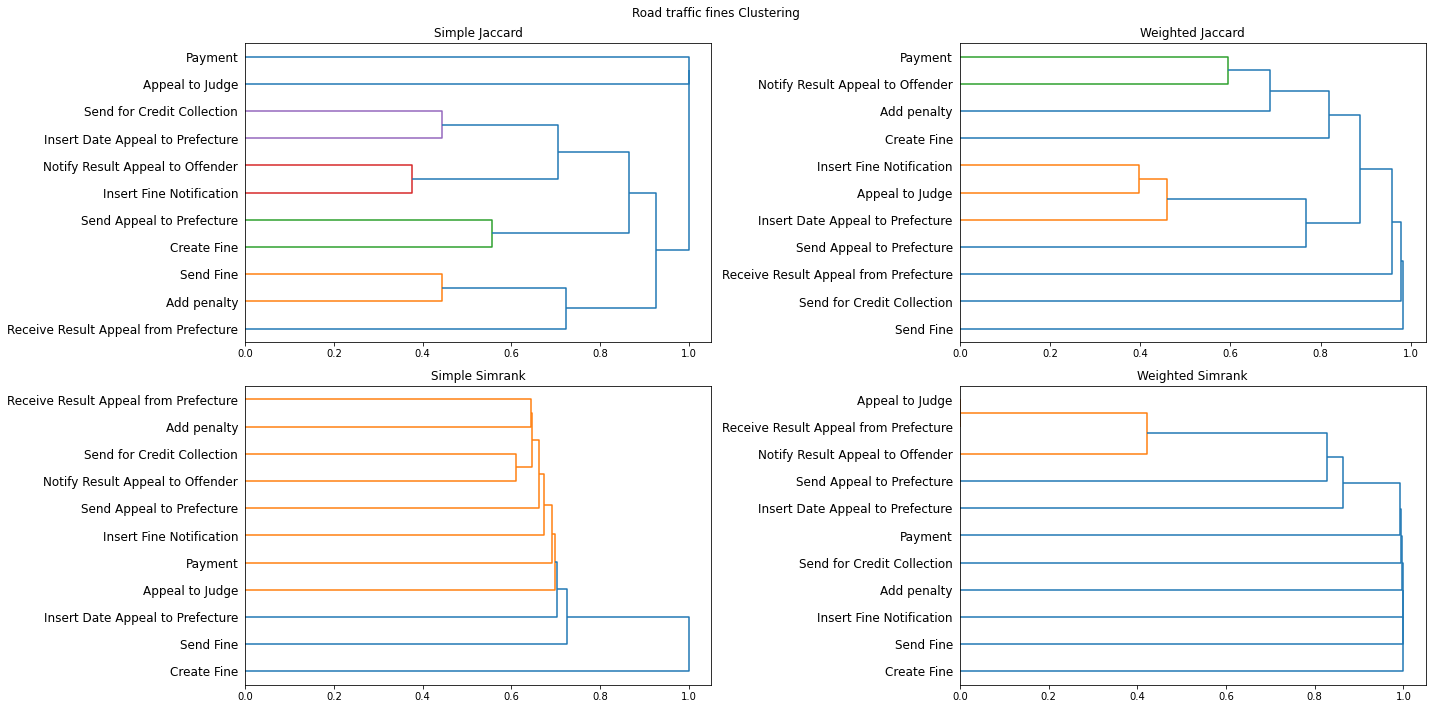

In [6]:
road_traffic = Log_processing.get_log("../logs/Road_Traffic_Fine_Management_Process.xes")
Comparison.show_dendrograms_for_event_log(road_traffic, "Road traffic fines Clustering", "Road_traffic_fines.jpg")

In [7]:
# Testing
'''
log = Log_processing.get_log("../logs/sepsis_event_log.xes")
num_levels = 5

simple_jaccard = Jaccard.Simple_Jaccard(log)
weighted_jaccard = Jaccard.Weighted_Jaccard(log)
simple_simrank = Simrank.Simple_Simrank(log)
weighted_simrank = Simrank.Weighted_Simrank(log)

simple_jaccard.perform_clustering(no_plot=True)
weighted_jaccard.perform_clustering(no_plot=True)
simple_simrank.perform_clustering(no_plot=True)
weighted_simrank.perform_clustering(no_plot=True)

Clustering.generate_hierarchy_file(simple_jaccard.get_linkage(), simple_jaccard.get_activities(), num_levels, "output_sepsis_simple_jaccard.csv")
Clustering.generate_hierarchy_file(weighted_jaccard.get_linkage(), weighted_jaccard.get_activities(), num_levels, "output_sepsis_weighted_jaccard.csv")
Clustering.generate_hierarchy_file(simple_simrank.get_linkage(), simple_simrank.get_activities(), num_levels, "output_sepsis_simple_simrank.csv")
Clustering.generate_hierarchy_file(weighted_simrank.get_linkage(), weighted_simrank.get_activities(), num_levels, "output_sepsis_weighted_simrank.csv")


log = Log_processing.get_log("../logs/BPI_Challenge_2013_incidents.xes")
num_levels = 5

simple_jaccard = Jaccard.Simple_Jaccard(log)
weighted_jaccard = Jaccard.Weighted_Jaccard(log)
simple_simrank = Simrank.Simple_Simrank(log)
weighted_simrank = Simrank.Weighted_Simrank(log)

simple_jaccard.perform_clustering(no_plot=True)
weighted_jaccard.perform_clustering(no_plot=True)
simple_simrank.perform_clustering(no_plot=True)
weighted_simrank.perform_clustering(no_plot=True)

Clustering.generate_hierarchy_file(simple_jaccard.get_linkage(), simple_jaccard.get_activities(), num_levels, "output_bpi_simple_jaccard.csv")
Clustering.generate_hierarchy_file(weighted_jaccard.get_linkage(), weighted_jaccard.get_activities(), num_levels, "output_bpi_weighted_jaccard.csv")
Clustering.generate_hierarchy_file(simple_simrank.get_linkage(), simple_simrank.get_activities(), num_levels, "output_bpi_simple_simrank.csv")
Clustering.generate_hierarchy_file(weighted_simrank.get_linkage(), weighted_simrank.get_activities(), num_levels, "output_bpi_weighted_simrank.csv")
'''

simple_jaccard = Jaccard.Simple_Jaccard(sepsis)
simple_jaccard.perform_clustering(no_plot=True)
Clustering.generate_hierarchy_file_with_dummies(simple_jaccard.get_activities(), simple_jaccard.get_distance_matrix(), simple_jaccard.get_linkage(), "out_sepsis_simple_jaccard_dummy.csv")

INFO  : Generating linkage from distances (tanglegram.tangle)
INFO  : Generating linkage from distances (tanglegram.tangle)
INFO  : Finished optimising at entanglement 0.21 (tanglegram.tangle)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


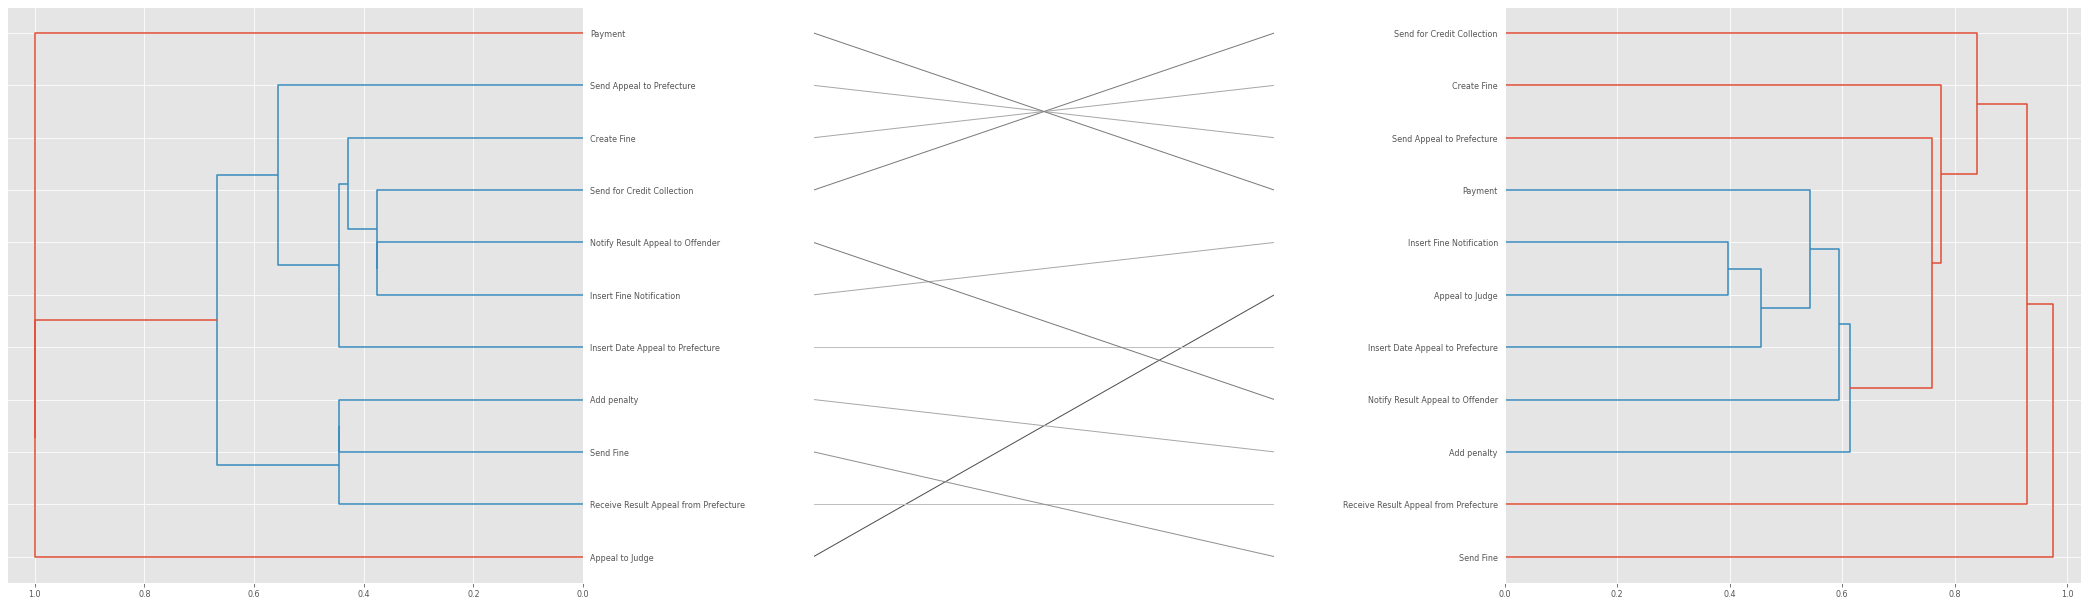

In [8]:
Comparison.show_tanglegram(Jaccard.Simple_Jaccard(road_traffic), Jaccard.Weighted_Jaccard(road_traffic))

parsing log, completed traces ::   0%|          | 0/1434 [00:00<?, ?it/s]

/home/myusername/Bachelor/Event_log_clustering/src/Comparison.py:72: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/home/myusername/Bachelor/Event_log_clustering/src/Comparison.py:113: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


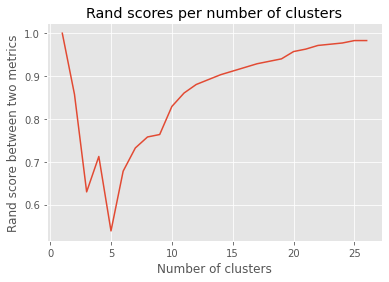

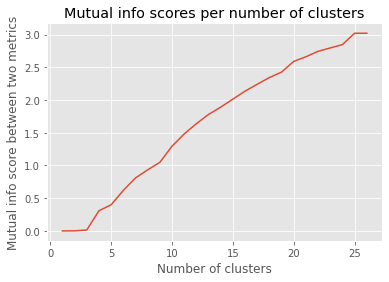

In [9]:
coselog = Log_processing.get_log("../logs/coselog.xes")
compare_jacc = Jaccard.Simple_Jaccard(coselog)
compare_simrank = Simrank.Simple_Simrank(coselog)

rand_scores = Comparison.compare_dendrogram_using_rand_score(compare_jacc, compare_simrank)
mutual_info_scores = Comparison.compare_dendrogram_using_mutual_info_score(compare_jacc, compare_simrank)